# Malaria Parasite Detection using Deep Learning

In this project I have used the publicly available dataset of blood smear cell images published by NIH. The dataset consists 
of equal counts of parasitized and uninfected cases of cell images ,i.e,
* 13,779 Parasitized cell images
* 13,779 Unifected cell images

The link to this dataset is [here](https://ceb.nlm.nih.gov/repositories/malaria-datasets/).

##### Introduction:
Malaria is a serious problem in the developing world with over 216 Million reported cases just in 2016. This disease is spread by mosquitoes and is caused by single celled parasitic organisms called plasmodium. Till date, diagnosis of malaria is done by microscopic examination, which is held as the “gold standard” for laboratory confirmation of malaria. This procedure can be tedious and possibly erroneous, with some subjectivity leading to inconsistent or incorrect diagnosis which may cause incorrect or untimely treatment or even result in the death of the patient. To solve this problem NIH proposed a deep learning solution - to automatically count parasites using CNN in digitized images of blood films. 

The Published paper of this work at NIH is [Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images](https://lhncbc.nlm.nih.gov/system/files/pub9752.pdf). 

In this paper they used following six pre-trained CNN's :
* A custom CNN architecture built by them
* ResNet-50
* Xception
* AlexNet
* VGG-16
* DenseNet-121

They used these models for feature extraction and subsequent training which in all took a little over 24 hours. They obtained 95.9% accuracy.

I think this strategy is not optimal as having so many models is computaionally inefficient. 

So, in this project I aim to build a custom CNN model using keras with following traits:
* Comparable accuracy with the NIH model
* Smaller architecture (model) which takes less time to train and is computationally efficient






In [1]:
# importing the necessray libraries
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# importing the necessary deep learning libraries
import keras
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import initializers
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


## File directory paths and image paths

In [3]:
# C:\Users\nayan\NNproject
project_folder = os.path.abspath(os.path.join('..', 'nayan','NNproject'))

# C:\Users\nayan\NNproject\image_dataset\cell_images
cell_images = os.path.join(project_folder, "image_dataset", "cell_images")

# parasitized
# C:\Users\nayan\NNproject\image_dataset\cell_images\Parasitized
parasitized_images = os.path.join(cell_images, "Parasitized")

# uninfected
# C:\Users\nayan\NNproject\image_dataset\cell_images\Uninfected
uninfected_images = os.path.join(cell_images, "Uninfected")

# C:\Users\nayan\NNproject\image_dataset\cell_images\Parasitized\*.png
p_images = glob(os.path.join(parasitized_images, "*.png"))
u_images = glob(os.path.join(uninfected_images, "*.png"))


print(uninfected_images)


C:\Users\nayan\NNproject\image_dataset\cell_images\Uninfected


## Plotting  Parasitized  and Uninfected images

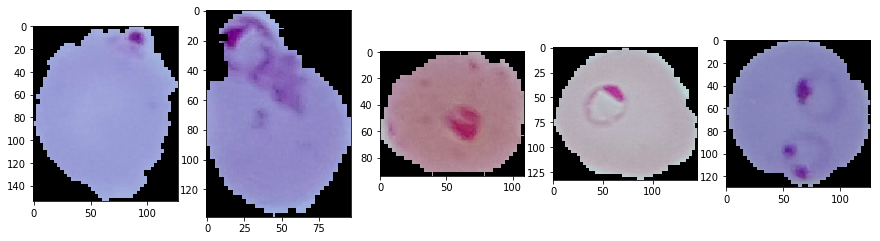

In [4]:
# randomly sampling 5 images
parasitized_random = random.sample(p_images, 5)

# plotting three images from parasitized folder
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(cv2.imread(parasitized_random[i]))

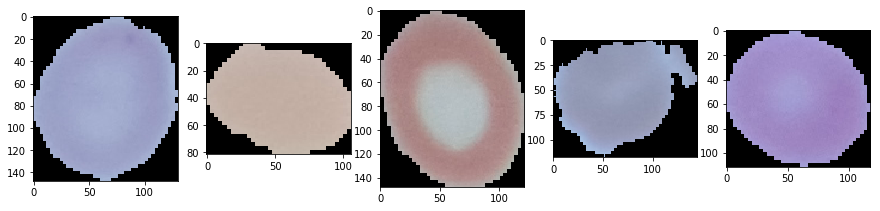

In [5]:
# randomly sampling 5 images
unifected_random = random.sample(u_images, 5)

# plotting resized images from parasitized folder
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(cv2.imread(unifected_random[i]))

In [6]:
# creating a list with all images
all_images = []
all_images.extend(p_images)
all_images.extend(u_images)
type(all_images) , len(all_images)

(list, 27558)

## Resizing the images and extracting image labels

In [7]:
def resize_image(images_list, img_width, img_height):
    '''
    parameters : images_list - list of paths for images
                 img_width - width of resized image
                 img_height - height of resized image
    does : resizes the original images and create an array with image dimensions and labels for that images
    return : numpy array of resized images(X_images) and lables(Y_labels) , total_images processed for spot check
    '''
    total_images = len(images_list)
    X_images = [] # images as aarays
    Y_labels = [] # labels Parasitized or Uninfected
    for img in images_list:
        # resizing the image and adding it to X_images array
        original_image = cv2.imread(img)
        resize_image = cv2.resize(original_image, (img_width,img_height), interpolation=cv2.INTER_CUBIC)
        X_images.append(resize_image)
        
        # adding label of the image to Y_labels lsit
        label = img.split('\\')[-2]
        Y_labels.append(label)
        
    X_images = np.array(X_images)
    Y_labels = np.array(Y_labels)
    
    return X_images,Y_labels,total_images

In [8]:
# Resizing the images to 64 x 64 x 3 size
X_im , Y_lb, images_processed = resize_image(all_images, img_width = 64, img_height = 64)

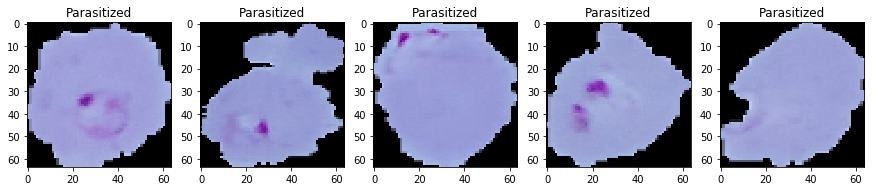

In [9]:
# plotting 5 parasitized and uninfected resized images
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_im[i])
    plt.title(str(Y_lb[i]))

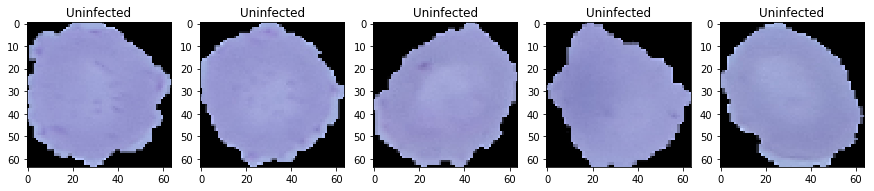

In [10]:
plt.figure(figsize=(15,15))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(X_im[-i])
    plt.title(str(Y_lb[-i]))

#### Checking and setting correct image shape, data type.

In [11]:
#checking shape of images and labels
X_im.shape , Y_lb.shape

((27558, 64, 64, 3), (27558,))

In [12]:
# converting labels to categorical data
from sklearn.preprocessing import LabelEncoder
# integer encode
label_encoder = LabelEncoder()
Y_int = label_encoder.fit_transform(Y_lb)
print(label_encoder.inverse_transform([0,1])), Y_int.shape , type(Y_int) , type(Y_int[0])

['Parasitized' 'Uninfected']


C:\Users\nayan\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(None, (27558,), numpy.ndarray, numpy.int64)

* NOTE: 0 - Parasitized, 1 - Uninfected

In [13]:
#converting labels to categorical data
from keras.utils import to_categorical
Y_cat = to_categorical(Y_int, num_classes = 2)

In [14]:
# rechecking the shapes
X_im.shape , Y_cat.shape

((27558, 64, 64, 3), (27558, 2))

In [15]:
# checking data type
X_im.dtype, Y_cat.dtype

(dtype('uint8'), dtype('float64'))

In [16]:
# changing data type of images to float32
X_im = X_im.astype("float32")
X_im.dtype

dtype('float32')

### Spillting the data in training(~64%) , validation(~16%) and test(20%) 

In [17]:
# X and test set split
X,test_X,label,test_label = train_test_split(X_im,Y_cat,test_size=0.2,random_state=123)

# further splitting X into training and validation sets
train_X,valid_X,train_label,valid_label = train_test_split(X,label,test_size=0.2,random_state=123)                                                           
                                                             

In [18]:
#checking dimensions of the datasets
train_X.shape , train_label.shape, valid_X.shape, valid_label.shape

((17636, 64, 64, 3), (17636, 2), (4410, 64, 64, 3), (4410, 2))

In [19]:
# checking dimensions of the test set
test_X.shape, test_label.shape

((5512, 64, 64, 3), (5512, 2))

## Affine Image data augmentation techniques.

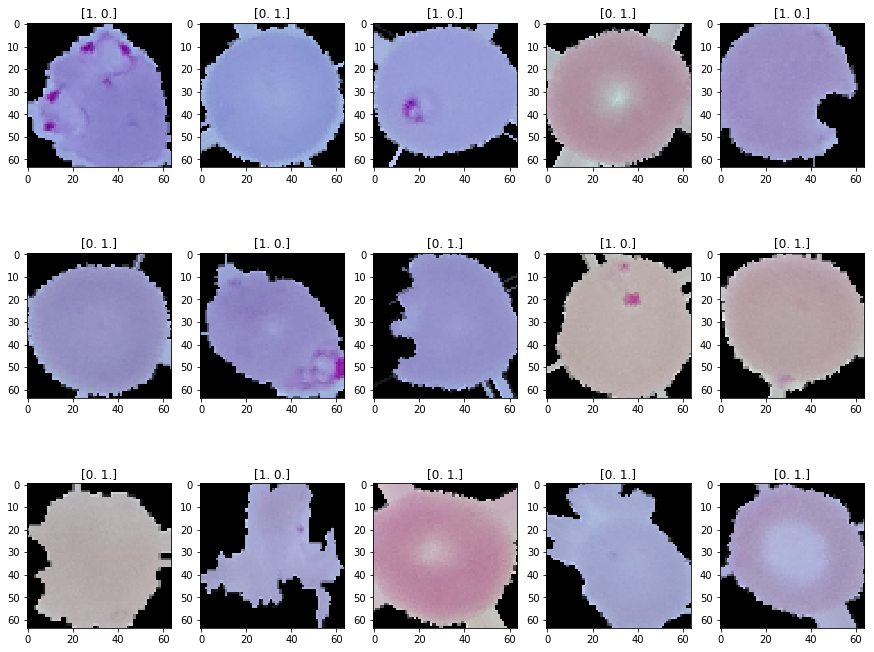

In [20]:
# affine transformations shifting pixels , rotating 

# define data preparation
train_datagen = ImageDataGenerator(rescale= 1/255.0,
                             zoom_range=0.05,
                             rotation_range=30,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             shear_range=0.05,
                             horizontal_flip=True,
                             fill_mode="nearest")


# define data generator for testing and validation augmented data preparation (only rescaling)
valid_datagen = ImageDataGenerator(rescale= 1/255.0)


# configure batch size and retrieve one batch of images
for X_batch1, y_batch1 in train_datagen.flow(train_X, train_label, batch_size=15):
    # create a grid of 3 x 5 images
    plt.figure(figsize=(15,12))
    for i in range(0, 15):
        plt.subplot(3,5,i+1)
        plt.imshow(X_batch1[i])
        plt.title(str(y_batch1[i]))
    # show the plot
    plt.show()
    break

In [21]:
# initializing train and validation image data generators
train_data_gen = train_datagen.flow(train_X, train_label, batch_size = 64, shuffle = True)
valid_data_gen = valid_datagen.flow(valid_X, valid_label, batch_size = 64, shuffle = False)
test_data_gen = valid_datagen.flow(test_X, test_label, batch_size = 64, shuffle = False)

In [22]:
#cnn params
batch_size = 64
epochs = 50
classes = 2
channels = 3
height, width = 64, 64

In [0]:
#cnn model
def cnn_arch(height, width, classes, channels):
    model = Sequential()
    
    input_img_shape = (height, width, channels)
    
    model.add(Conv2D(32, (3,3), activation = 'relu', padding ='same' ,input_shape = input_img_shape))
    model.add(Conv2D(32, (3,3), activation = 'relu', padding ='same',strides=2))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.5))

    model.add(BatchNormalization())
    
    model.add(Conv2D(64, (3,3), activation = 'relu', padding ='same',strides=2))
    model.add(Conv2D(64, (3,3), activation = 'relu', padding ='same',strides=2))
    model.add(MaxPooling2D(2,2))
    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dense(classes, activation = 'sigmoid'))
    
    return model

In [0]:
# instantiate the model

train_model = cnn_arch(height = height, width = width, classes = classes, channels = channels)
train_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)    

In [0]:
#compile the model SGD AMD MOMENTUM
optim = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)

train_model.compile(loss = 'binary_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [0]:
#fit the model DIFFERENT ARCHITECTURE BINARY CROSS ENTROPY LOSS, OPTIMIZER SGD Twice input AND SIGMOID ----WITH DROPOUT
model_augdata = train_model.fit_generator(train_data_gen, steps_per_epoch = len(train_X)// batch_size, epochs = epochs, 
                                          validation_data = valid_data_gen,validation_steps=len(valid_X) // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
275/275 [==============================] - 22s 80ms/step - loss: 0.6829 - acc: 0.5935 - val_loss: 0.8677 - val_acc: 0.4999
Epoch 2/30
275/275 [==============================] - 20s 71ms/step - loss: 0.5883 - acc: 0.6892 - val_loss: 1.5323 - val_acc: 0.6583
Epoch 3/30
275/275 [==============================] - 18s 67ms/step - loss: 0.2862 - acc: 0.8990 - val_loss: 0.4827 - val_acc: 0.8465
Epoch 4/30
275/275 [==============================] - 18s 66ms/step - loss: 0.2025 - acc: 0.9339 - val_loss: 0.2080 - val_acc: 0.9299
Epoch 5/30
275/275 [==============================] - 18s 67ms/step - loss: 0.1891 - acc: 0.9396 - val_loss: 0.2063 - val_acc: 0.9263
Epoch 6/30
275/275 [==============================] - 19s 70ms/step - loss: 0.1748 - acc: 0.9429 - val_loss: 0.2125 - val_acc: 0.9242
Epoch 7/30
275/275 [==============================] - 19s 68ms/step - loss: 0.1716 - acc: 0.9459 - val_loss: 0.1901 - val_acc: 0.9475
Epoch 8/30
275

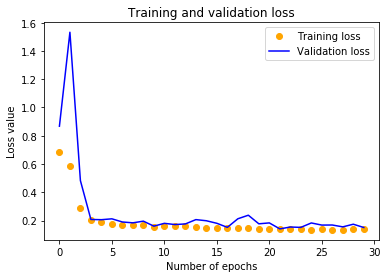

In [0]:
# plotting training and validation loss

loss = model_augdata.history['loss']
val_loss = model_augdata.history['val_loss']
epochs_range = range(epochs)
plt.figure()
plt.plot(epochs_range, loss, 'bo', color = 'orange' , label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss value')
plt.legend()
plt.show()

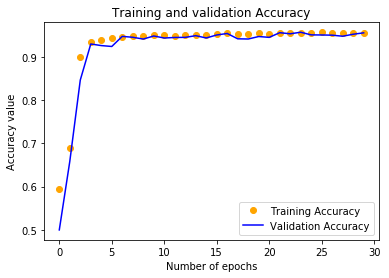

In [0]:
# plotting training and validation accuracy

acc = model_augdata.history['acc']
val_acc = model_augdata.history['val_acc']
plt.figure()
plt.plot(epochs_range, acc, 'bo', color = 'orange' , label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

In [0]:
# evaluating the model on test data
prediction_class = train_model.predict_generator(test_data_gen, steps = (len(test_X) // batch_size) + 1 )

In [0]:
#printing classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.argmax(test_label, axis = 1),np.argmax(prediction_class, axis = 1)))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2767
           1       0.94      0.98      0.96      2745

   micro avg       0.96      0.96      0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



In [0]:
# Test set accuracy
from sklearn.metrics import accuracy_score
print('Test Accuracy Score :',(accuracy_score(np.argmax(test_label, axis = 1),np.argmax(prediction_class, axis = 1)) *100) , '%')

Test Accuracy Score : 95.75471698113208 %


In [0]:
# printing confucion matrix
cm = confusion_matrix(np.argmax(test_label, axis = 1),np.argmax(prediction_class, axis = 1) , labels = [0 ,1])
cm

array([[2588,  179],
       [  55, 2690]])

Test Images (sample)


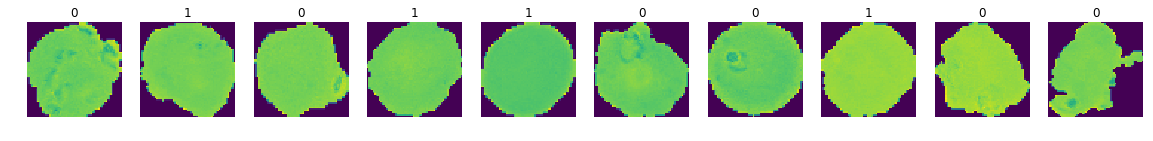

Prediction of Test Images (sample)


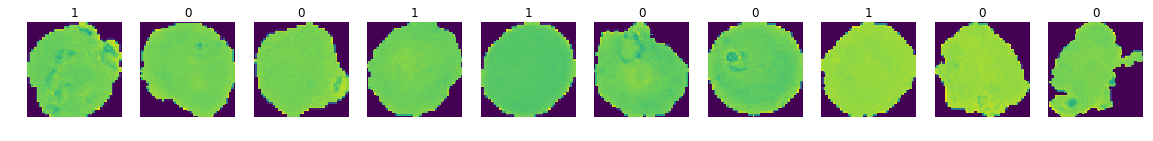

In [0]:
# plotting test samples and prediction results for those test samples
plt.figure(figsize=(20, 4))
print("Test Images (sample)")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_X[i, ..., 0])
    plt.title(str(np.argmax(test_label, axis = 1)[i]))
    plt.axis('off')
plt.show()    
plt.figure(figsize=(20, 4))
print("Prediction of Test Images (sample)")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_X[i, ..., 0])
    plt.title(str(np.argmax(prediction_class, axis = 1)[i]))
    plt.axis('off')
plt.show()

## Result:

I was able to built a CNN model that trained significalty faster than the NIH model (~ 10 mins) and also had a comparable performance if not better (95.75% accuracy). 